# **Homework 2 - Semantic Segmentation**

Objective: Implement a U-Net Network for semantic segmentation.



Dataset:

<figure>
<center>
<img src= 'https://raw.githubusercontent.com/mabelortega/DL_Semantic_Segmentation/main/Figures/drawing1.png'/>
</figure>

You must train the network model by using these images [https://drive.google.com/file/d/1TU2nTVGS2932hRs1u-ma4r3vmgqHRbMO/view?usp=sharing]. Image_Train.tif and Reference_Train.tif images and it must be evaluated on Image_Test.tif and Reference_Test.tif images. You can use this notebook that contains some basic functions.

Experimental Protocol

Load the input data
1.     Load the images provided from 2D Semantic Labeling-Vaihingen dataset using the function load_tiff_image(image) and normalize the data into the range [0,1] using the function normalization (image)

Train the FCN model
2.     To train the FCN model you need patches as input. You must extract patches of size w-by-w-by-c pixels from Image_Train and patches with size w-by-w from Reference_Train. The number of patches and the w must be chosen based on the input size of network.

3.     Split randomly the training patches into two sets: Training (80%) and validation (20%).

4.     Convert the patches of the Reference image into one-hot encoding base on the number of classes. Hint: Use the function tf.keras.utils.to_categorical.

5.     Create the function of the U-Net model - Using skip connections: Hint: use tensorflow.keras.layers.concatenate

6.     For training, use the weighted_categorical_crossentropy as a loss function. Hint: To compute the weights you must count the number of pixels of each class and apply the formula: w_i = #total_pixels / #pixels_of_class_i



7.     Train the model using Train_model() function, which has as input the training and validation patches. You must the best model adding the early stop strategy with patience equal to 10.

8.     Extract patches from the test images and test the model using Test(model, patch_test).

9.     Reconstruct the prediction (whole test image)

The report must present the classification results as label images, and report accuracy metrics (overall and average class accuracies, F1-score) you also must change the size of the extracted patches to compare the results (32x32, 64x64, 128x128)

# **Import the libraries**

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from osgeo import ogr, gdal
from sklearn.utils import shuffle
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from matplotlib import colors

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# load the data to personal google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_path = '/content/drive/MyDrive/Colab Notebooks'

!gdown 1TU2nTVGS2932hRs1u-ma4r3vmgqHRbMO
!unrar e images.rar

Mounted at /content/drive
Downloading...
From: https://drive.google.com/uc?id=1TU2nTVGS2932hRs1u-ma4r3vmgqHRbMO
To: /content/images.rar
100% 24.9M/24.9M [00:01<00:00, 24.2MB/s]

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from images.rar

Extracting  Image_Test.tif                                                16% 33% 50% 58%  OK 
Extracting  Reference_Test.tif                                            60%  OK 
Extracting  Image_Train.tif                                               76% 93% 99%  OK 
Extracting  Reference_Train.tif                                           99%  OK 
All OK


# **Define the functions**

In [ ]:
def load_tiff_image(image):
  gdal_header = gdal.Open(image)
  img = gdal_header.ReadAsArray()
  return img

def normalization(image):
  image_reshaped = image.reshape((image.shape[0]*image.shape[1]),image.shape[2])
  scaler = MinMaxScaler(feature_range=(0,1))
  scaler = scaler.fit(image_reshaped)
  image_normalized_ = scaler.fit_transform(image_reshaped)
  image_normalized = image_normalized_.reshape(image.shape[0],image.shape[1],image.shape[2])
  return image_normalized

def extract_patches(image, reference, patch_size, stride):
  patches_image = []
  patches_reference = []
  height, width, _ = image.shape

  for y in range(0, height - patch_size + 1, stride):
      for x in range(0, width - patch_size + 1, stride):
          image_patch = image[y:y+patch_size, x:x+patch_size, :]
          reference_patch = reference[y:y+patch_size, x:x+patch_size,:]
          patches_image.append(np.asarray(image_patch))
          patches_reference.append(np.asarray(reference_patch))

  patches_image = np.asarray(patches_image)
  patches_reference = np.asarray(patches_reference)

  return patches_image, patches_reference

# input_shape = (w, w, c), n_classes = 5
def unet(input_shape, n_classes):
  input_img = Input(input_shape)

  conv1 = Conv2D(64, 3, activation='relu', padding='same')(input_img)
  conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

  conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

  conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
  conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

  up6 = Conv2DTranspose(512, (2, 2), strides=(2,2), padding='same')(conv5)
  concat6 = Concatenate(axis=3)([conv4, up6])
  conv6 = Conv2D(512, 3, activation='relu', padding='same')(concat6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

  up7 = Conv2DTranspose(256, (2, 2), strides=(2,2), padding='same')(conv6)
  concat7 = Concatenate(axis=3)([conv3, up7])
  conv7 = Conv2D(256, 3, activation='relu', padding='same')(concat7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

  up8 = Conv2DTranspose(128, (2, 2), strides=(2,2), padding='same')(conv7)
  concat8 = Concatenate(axis=3)([conv2, up8])
  conv8 = Conv2D(128, 3, activation='relu', padding='same')(concat8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

  up9 = Conv2DTranspose(64, (2, 2), strides=(2,2), padding='same')(conv8)
  concat9 = Concatenate(axis=3)([conv1, up9])
  conv9 = Conv2D(64, 3, activation='relu', padding='same')(concat9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

  output = Conv2D(n_classes,(1,1), activation = 'softmax')(conv9)
  return Model(inputs = input_img, outputs = output, name='U-Net')

def weighted_categorical_crossentropy(weights):
        """
        A weighted version of keras.objectives.categorical_crossentropy

        Variables:
            weights: numpy array of shape (C,) where C is the number of classes

        Usage:
            weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
            loss = weighted_categorical_crossentropy(weights)
            model.compile(loss=loss,optimizer='adam')
        """
        weights = K.variable(weights)
        def loss(y_true, y_pred):
            # scale predictions so that the class probas of each sample sum to 1
            y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
            # clip to prevent NaN's and Inf's
            y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
            loss = y_true * K.log(y_pred) + (1-y_true) * K.log(1-y_pred)
            loss = loss * weights
            loss = - K.mean(loss, -1)
            return loss
        return loss

def Train_model(net, patches_train, patches_tr_lb_h, patches_val, patches_val_lb_h, batch_size, epochs, model_name):
  print('Start training.. ')

  epochs_without_improvement = 0
  for epoch in range(epochs):
    loss_tr = np.zeros((1 , 2))
    loss_val = np.zeros((1 , 2))
    # Computing the number of batchs
    n_batchs_tr = patches_train.shape[0]//batch_size
    # Random shuffle the data
    patches_train , patches_tr_lb_h = shuffle(patches_train , patches_tr_lb_h , random_state = 0)

    # Training the network per batch
    for  batch in range(n_batchs_tr):
      x_train_b = patches_train[batch * batch_size : (batch + 1) * batch_size , : , : , :]
      y_train_h_b = patches_tr_lb_h[batch * batch_size : (batch + 1) * batch_size , :, :, :]
      loss_tr = loss_tr + net.train_on_batch(x_train_b , y_train_h_b)

    # Training loss
    loss_tr = loss_tr/n_batchs_tr
    print("%d [Training loss: %f , Train acc.: %.2f%%]" %(epoch , loss_tr[0 , 0], 100*loss_tr[0 , 1]))

    # Computing the number of batchs
    n_batchs_val = patches_val.shape[0]//batch_size

    # Evaluating the model in the validation set
    for  batch in range(n_batchs_val):
      x_val_b = patches_val[batch * batch_size : (batch + 1) * batch_size , : , : , :]
      y_val_h_b = patches_val_lb_h[batch * batch_size : (batch + 1) * batch_size , :, :, :]
      loss_val = loss_val + net.test_on_batch(x_val_b , y_val_h_b)

    # validation loss
    loss_val = loss_val/n_batchs_val
    print("%d [Validation loss: %f , Validation acc.: %.2f%%]" %(epoch , loss_val[0 , 0], 100*loss_val[0 , 1]))

    # saving best model
    if epoch == 0:
      best_acc = loss_val[0, 1]
    else:
      if loss_val[0, 1] > best_acc:
        best_acc = loss_val[0, 1]
        print(f"Saved with accuracy: {best_acc}")
        net.save(root_path + model_name + ".h5")

    # implementation of early stopping
    if epoch == 0:
      best_loss_val = loss_val[0,0]
    elif loss_val[0,0] < best_loss_val:
      best_loss_val = loss_val[0,0]
      epochs_without_improvement = 0
    else:
      epochs_without_improvement += 1

    if epochs_without_improvement >= 10:
      print("Early stopping at epoch: ", epoch)
      break

def Test(model, patch_test):
  result = model.predict(patch_test)
  predicted_class = np.argmax(result, axis=-1)
  return predicted_class

def compute_metrics(true_labels, predicted_labels):
  accuracy = 100*accuracy_score(true_labels, predicted_labels)
  print("Accuracy:", accuracy)
  f1score = 100*f1_score(true_labels, predicted_labels, average=None)
  print("F1 Score:", f1score)
  recall = 100*recall_score(true_labels, predicted_labels, average=None)
  print("Recall:", recall)
  precision = 100*precision_score(true_labels, predicted_labels, average=None)
  print("Precision:", precision)

In [ ]:
class ModelPipeline():
  def __init__(self, patch_size, stride, model_name):
    self.patch_size = patch_size
    self.stride = stride
    self.model_name = model_name

  def load_images(self):
    # loading to nb
    self.img_train = load_tiff_image("Image_Train.tif")
    self.img_test = load_tiff_image("Image_Test.tif")
    self.ref_train = load_tiff_image("Reference_Train.tif")
    self.ref_test = load_tiff_image("Reference_Test.tif")
    print("Images are loaded!")

  def normalize_images(self):
    # normalize images
    self.img_train = normalization(self.img_train)
    self.img_train = np.transpose(self.img_train, (1,2,0))

    self.img_test = normalization(self.img_test)
    self.img_test = np.transpose(self.img_test, (1,2,0))

    self.ref_train = normalization(self.ref_train)
    self.ref_train = np.transpose(self.ref_train, (1,2,0))

    self.ref_test = normalization(self.ref_test)
    self.ref_test = np.transpose(self.ref_test, (1,2,0))

    print("Images are normalized!")

  def process_before_training(self):
    # extract patches
    self.patches_img_full_train, self.patches_ref_full_train = extract_patches(self.img_train, self.ref_train, self.patch_size, self.stride)
    self.patches_img_test, self.patches_ref_test = extract_patches(self.img_test, self.ref_test, self.patch_size, self.stride)

    # divide into train and validation sets
    total_elements = len(self.patches_img_full_train)
    cut = int(0.8 *total_elements)
    indices = list(range(total_elements))
    random.shuffle(indices)

    self.patches_img_train = np.array([self.patches_img_full_train[i] for i in indices[:cut]])
    self.patches_img_val = np.array([self.patches_img_full_train[i] for i in indices[cut:]])

    self.patches_ref_train = np.array([self.patches_ref_full_train[i] for i in indices[:cut]])
    self.patches_ref_val= np.array([self.patches_ref_full_train[i] for i in indices[cut:]])

    # making images grayscale
    self.patches_ref_train = np.dot(self.patches_ref_train[...,:3], [0.2989, 0.5870, 0.1140])
    self.patches_ref_val = np.dot(self.patches_ref_val[...,:3], [0.2989, 0.5870, 0.1140])
    self.ref_train = np.dot(self.ref_train[...,:3], [0.2989, 0.5870, 0.1140])

    # using LabelEncoder to allow one hot encoding
    self.label_encoder = LabelEncoder()
    self.label_encoder.fit_transform(self.patches_ref_train.ravel())
    self.patches_ref_train = self.label_encoder.transform(self.patches_ref_train.ravel()).reshape(self.patches_ref_train.shape)
    self.patches_ref_val = self.label_encoder.transform(self.patches_ref_val.ravel()).reshape(self.patches_ref_val.shape)
    self.ref_train = self.label_encoder.transform(self.ref_train.ravel()).reshape(self.ref_train.shape)

    # one-hot encoding
    self.patches_ref_train = tf.keras.utils.to_categorical(self.patches_ref_train, num_classes=5)
    self.patches_ref_val = tf.keras.utils.to_categorical(self.patches_ref_val, num_classes=5)
    self.ref_train = tf.keras.utils.to_categorical(self.ref_train, num_classes=5)

    print("You have extracted patches, divided into train and validation sets, turned images into grayscale & applied one-hot encoding!")

  def print_some_patch(self, n):
    plt.imshow(self.patches_ref_train[n])

  def training(self, epochs):
    # initialize weights
    init_weights = np.zeros((5))
    for i in range(5):
      init_weights[i] = np.sum(self.ref_train[:, :, i] == 1)
    init_weights = sum(init_weights)/init_weights

    # Train the model
    adam = Adam(lr = 0.0001 , beta_1=0.9)
    net = unet((self.patch_size, self.patch_size, 3), 5)
    loss = weighted_categorical_crossentropy(init_weights)
    #net.summary()
    net.compile(loss = loss, optimizer=adam , metrics=['accuracy'])

    Train_model(net, self.patches_img_train, self.patches_ref_train, self.patches_img_val, self.patches_ref_val, 10, epochs, self.model_name)

  def get_best_model(self):
    # load the best model
    model = load_model(root_path + self.model_name + ".h5",
                      custom_objects = {"loss": weighted_categorical_crossentropy})

    # test the model
    self.predicted_labels = Test(model, self.patches_img_test)

    # turn test image to categorical
    self.patches_ref_test = np.dot(self.patches_ref_test[...,:3], [0.2989, 0.5870, 0.1140])
    self.patches_ref_test = self.label_encoder.transform(self.patches_ref_test.ravel()).reshape(self.patches_ref_test.shape)

    # Metrics
    compute_metrics(self.patches_ref_test.reshape(-1,1), self.predicted_labels.reshape(-1,1))

  def reconstruct_test_image(self):
    ncols = (self.img_test.shape[1] // self.patch_size) * self.patch_size
    nrows = (self.img_test.shape[0] // self.patch_size) * self.patch_size

    full_image = np.zeros((nrows, ncols))
    for i, patch in enumerate(self.predicted_labels):
        row_start = (i // (ncols // self.patch_size)) * self.patch_size
        row_end = row_start + self.patch_size
        col_start = (i % (ncols // self.patch_size)) * self.patch_size
        col_end = col_start + self.patch_size
        full_image[row_start:row_end, col_start:col_end] = patch

    fig, ax = plt.subplots(1,1)
    cmap = colors.ListedColormap(['#0000FF', '#00FF00', '#00FFFF', '#FFFF00', '#FFFFFF'])
    ax.imshow(full_image, cmap=cmap)
    ax.set_title(f"Reconstrução da imagem ({self.patch_size}x{self.patch_size})")
    plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
    plt.show()

## **Modelo 1:** patch_size = 32x32

In [ ]:
# model 1 has patch_size = 32x32 and stride = 32
model1 = ModelPipeline(patch_size = 32, stride = 32, model_name = "model1")

In [ ]:
model1.load_images()
model1.normalize_images()

Images are loaded!
Images are normalized!


In [ ]:
model1.process_before_training()

You have extracted patches, divided into train and validation sets, turned images into grayscale & applied one-hot encoding!


In [ ]:
model1.training(epochs = 20)

Start training.. 
0 [Training loss: 3.503546 , Train acc.: 43.26%]
0 [Validation loss: 2.443638 , Validation acc.: 52.59%]
1 [Training loss: 3.130293 , Train acc.: 49.21%]
1 [Validation loss: 2.285315 , Validation acc.: 55.39%]
Saved with accuracy: 0.5539426126695693
2 [Training loss: 2.784392 , Train acc.: 54.24%]
2 [Validation loss: 2.408585 , Validation acc.: 56.52%]
Saved with accuracy: 0.5651616514363187
3 [Training loss: 2.657149 , Train acc.: 56.53%]
3 [Validation loss: 2.094805 , Validation acc.: 54.58%]
4 [Training loss: 2.517726 , Train acc.: 58.33%]
4 [Validation loss: 1.959181 , Validation acc.: 56.74%]
Saved with accuracy: 0.5674015144084362
5 [Training loss: 2.449409 , Train acc.: 60.17%]
5 [Validation loss: 2.055690 , Validation acc.: 54.53%]
6 [Training loss: 2.337768 , Train acc.: 63.31%]
6 [Validation loss: 1.833924 , Validation acc.: 64.93%]
Saved with accuracy: 0.6492925118258659
7 [Training loss: 2.261189 , Train acc.: 64.24%]
7 [Validation loss: 2.130883 , Validat

In [ ]:
model1.get_best_model()

218/218 [==============================] - 5s 18ms/step
Accuracy: 67.92929136849108
F1 Score: [76.90256696 70.7117752  58.47061914  9.57376637 70.48911285]
Recall: [83.55485468 73.82428796 51.57197045  5.63567783 76.73157127]
Precision: [71.23141955 67.85109865 67.49990652 31.7831074  65.1859432 ]


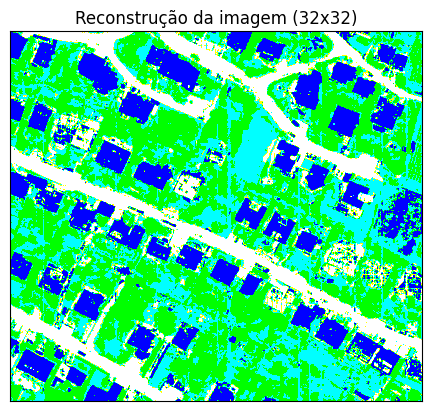

In [ ]:
model1.reconstruct_test_image()

## **Modelo 2:** patch_size = 64x64

In [ ]:
model2 = ModelPipeline(patch_size = 64, stride = 64, model_name = "model2")

In [ ]:
model2.load_images()
model2.normalize_images()

Images are loaded!
Images are normalized!


In [ ]:
model2.process_before_training()

You have extracted patches, divided into train and validation sets, turned images into grayscale & applied one-hot encoding!


In [ ]:
model2.training(epochs = 20)

Start training.. 
0 [Training loss: 5.028380 , Train acc.: 30.91%]
0 [Validation loss: 3.437978 , Validation acc.: 48.69%]
1 [Training loss: 3.044795 , Train acc.: 47.06%]
1 [Validation loss: 2.842284 , Validation acc.: 51.82%]
Saved with accuracy: 0.518205463886261
2 [Training loss: 2.932792 , Train acc.: 51.38%]
2 [Validation loss: 2.291985 , Validation acc.: 57.52%]
Saved with accuracy: 0.5752091083837592
3 [Training loss: 2.757454 , Train acc.: 55.47%]
3 [Validation loss: 2.195814 , Validation acc.: 58.83%]
Saved with accuracy: 0.5883035439512004
4 [Training loss: 2.616740 , Train acc.: 55.42%]
4 [Validation loss: 2.137555 , Validation acc.: 56.69%]
5 [Training loss: 2.640075 , Train acc.: 55.55%]
5 [Validation loss: 2.069026 , Validation acc.: 58.63%]
6 [Training loss: 2.512777 , Train acc.: 56.55%]
6 [Validation loss: 2.238571 , Validation acc.: 57.18%]
7 [Training loss: 2.465231 , Train acc.: 59.20%]
7 [Validation loss: 2.014922 , Validation acc.: 60.83%]
Saved with accuracy: 0.

In [ ]:
model2.get_best_model()

54/54 [==============================] - 5s 56ms/step
Accuracy: 63.72487172658071
F1 Score: [65.84328306 69.44289924 56.41365496  0.         65.12038357]
Recall: [63.35089628 71.62486551 49.53469491  0.         81.82092981]
Precision: [68.53981523 67.38994478 65.51131277  0.         54.08171443]


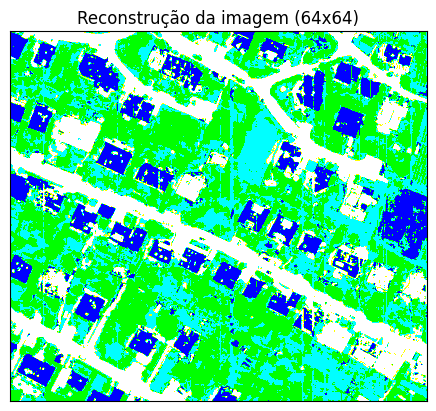

In [ ]:
model2.reconstruct_test_image()

## **Modelo 3:** patch_size = 128x128

In [ ]:
model3 = ModelPipeline(patch_size = 128, stride = 128, model_name = "model3")

In [ ]:
model3.load_images()
model3.normalize_images()

Images are loaded!
Images are normalized!


In [ ]:
model3.process_before_training()

You have extracted patches, divided into train and validation sets, turned images into grayscale & applied one-hot encoding!


In [ ]:
model3.training(epochs = 20)

Start training.. 
0 [Training loss: 10.369227 , Train acc.: 25.97%]
0 [Validation loss: 6.659537 , Validation acc.: 29.07%]
1 [Training loss: 3.985875 , Train acc.: 27.72%]
1 [Validation loss: 4.211482 , Validation acc.: 34.90%]
Saved with accuracy: 0.34899292290210726
2 [Training loss: 3.484744 , Train acc.: 31.49%]
2 [Validation loss: 4.135432 , Validation acc.: 48.11%]
Saved with accuracy: 0.4811486780643463
3 [Training loss: 2.729010 , Train acc.: 37.83%]
3 [Validation loss: 4.263159 , Validation acc.: 36.25%]
4 [Training loss: 2.649235 , Train acc.: 44.53%]
4 [Validation loss: 4.019830 , Validation acc.: 36.42%]
5 [Training loss: 2.501765 , Train acc.: 48.34%]
5 [Validation loss: 3.719229 , Validation acc.: 54.97%]
Saved with accuracy: 0.5496972560882568
6 [Training loss: 2.383914 , Train acc.: 50.01%]
6 [Validation loss: 4.138812 , Validation acc.: 57.80%]
Saved with accuracy: 0.5779687523841858
7 [Training loss: 2.317926 , Train acc.: 52.30%]
7 [Validation loss: 3.998964 , Valid

In [ ]:
model3.get_best_model()

14/14 [==============================] - 7s 181ms/step
Accuracy: 62.01431785473983
F1 Score: [63.37791538 65.40828738 57.25974263  0.         64.51869623]
Recall: [66.25066642 60.11482231 53.50652741  0.         80.10609432]
Precision: [60.74394589 71.72400999 61.57921661  0.         54.00932326]


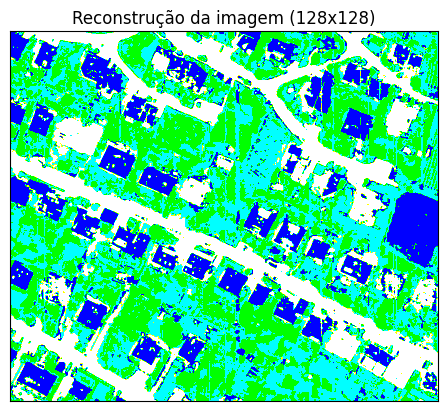

In [ ]:
model3.reconstruct_test_image()

## **Modelo 4:** patch_size = 64x64, stride = 16



In [ ]:
model4 = ModelPipeline(patch_size = 64, stride = 16, model_name = "model4")

In [ ]:
model4.load_images()
model4.normalize_images()

Images are loaded!
Images are normalized!


In [ ]:
model4.process_before_training()

In [ ]:
model4.training(epochs = 20)

In [ ]:
model4.get_best_model()